In [2]:
import os
import cv2
import numpy as np
import pickle
import zipfile
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Konfigurasi Gambar
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print("Library berhasil diimport.")

Library berhasil diimport.


In [3]:
# 1. Mount Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

PATH_ZIP = '/content/drive/MyDrive/Train.zip'
# ----------------------------------------------

# Folder Sementara
TEMP_DIR = '/content/temp_raw'
DB_DIR = '/content/dataset_wajah_crop' # Folder data bersih (crop wajah)

# Bersihkan folder lama jika ada (supaya tidak duplikat)
if os.path.exists(TEMP_DIR): shutil.rmtree(TEMP_DIR)
if os.path.exists(DB_DIR): shutil.rmtree(DB_DIR)
os.makedirs(TEMP_DIR, exist_ok=True)
os.makedirs(DB_DIR, exist_ok=True)

# Ekstrak
print("Mengekstrak dataset...")
with zipfile.ZipFile(PATH_ZIP, 'r') as zip_ref:
    zip_ref.extractall(TEMP_DIR)

# Deteksi root folder dalam zip
root_raw = TEMP_DIR
if 'Train' in os.listdir(TEMP_DIR) and os.path.isdir(os.path.join(TEMP_DIR, 'Train')):
    root_raw = os.path.join(TEMP_DIR, 'Train')

print(f"Dataset diekstrak di: {root_raw}")

Mounted at /content/drive
Mengekstrak dataset...
Dataset diekstrak di: /content/temp_raw/Train


In [4]:
print("\nMemulai Auto-Crop Wajah (Membersihkan Background)...")

# Load Detektor Wajah Bawaan OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

processed_count = 0
classes = sorted(os.listdir(root_raw))

for cls in classes:
    src_path = os.path.join(root_raw, cls)
    dst_path = os.path.join(DB_DIR, cls)

    if not os.path.isdir(src_path): continue
    os.makedirs(dst_path, exist_ok=True)

    for img_name in os.listdir(src_path):
        try:
            img_file = os.path.join(src_path, img_name)
            img = cv2.imread(img_file)
            if img is None: continue

            # Deteksi Wajah
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 4, minSize=(30,30))

            if len(faces) > 0:
                # Ambil wajah terbesar
                faces = sorted(faces, key=lambda x: x[2]*x[3], reverse=True)
                x, y, w, h = faces[0]
                # Tambah margin sedikit (padding)
                p = 20
                face_crop = img[max(0,y-p):y+h+p, max(0,x-p):x+w+p]

                # Resize ke 224x224
                face_crop = cv2.resize(face_crop, IMG_SIZE)

                # Simpan ke folder baru
                cv2.imwrite(os.path.join(dst_path, img_name), face_crop)
                processed_count += 1
            else:
                # Fallback: Jika wajah tidak ketemu, pakai gambar asli resize
                img_rz = cv2.resize(img, IMG_SIZE)
                cv2.imwrite(os.path.join(dst_path, img_name), img_rz)

        except Exception as e:
            print(f"Error file {img_name}: {e}")

print(f"Selesai! {processed_count} wajah berhasil di-crop.")
print(f"Lokasi dataset bersih: {DB_DIR}")


Memulai Auto-Crop Wajah (Membersihkan Background)...
Selesai! 262 wajah berhasil di-crop.
Lokasi dataset bersih: /content/dataset_wajah_crop


In [5]:
print("\nTAHAP TRAINING (FINE-TUNING)...")

# 1. Data Generator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.2 # 20% untuk validasi saat training
)

train_generator = train_datagen.flow_from_directory(
    DB_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    DB_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# 2. Bangun Model DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=IMG_SIZE+(3,))

# Unfreeze beberapa layer terakhir agar model beradaptasi dengan wajah mahasiswa
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Tambahkan layer klasifikasi (Head)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 3. Compile & Latih
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print("Mulai Melatih...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10, # 10 Epoch cukup untuk adaptasi fitur
    verbose=1
)

print("Training Selesai. Model sudah mengenal wajah mahasiswa.")


TAHAP TRAINING (FINE-TUNING)...
Found 266 images belonging to 70 classes.
Found 1 images belonging to 70 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Mulai Melatih...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.0144 - loss: 5.3473 - val_accuracy: 0.0000e+00 - val_loss: 4.4519
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - accuracy: 0.0027 - loss: 5.1527 - val_accuracy: 0.0000e+00 - val_loss: 4.6655
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 427ms/step - accuracy: 0.0031 - loss: 5.0965 - val_accuracy: 0.0000e+00 - val_loss: 4.0978
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.0282 - loss: 4.7173 - val_accuracy: 0.0000e+00 - val_loss: 3.9293
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - accuracy: 0.0188 - loss: 4.7280 - val_accuracy: 0.0000e+00 - val_loss: 3.1773
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 447ms/step - accuracy: 0.0506 - loss: 4.5489 - val_accuracy: 0.0000e+00 - val_loss: 3.5162
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step - accuracy: 0.0673 - loss: 4.5428 - val_accuracy: 0.0000e+00 - val_loss: 3.0316
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.0287 - loss: 4.5672 - val_ac

In [11]:
print("Mengkonversi Model ke Feature Extractor...")

# Ambil output dari layer GlobalAveragePooling2D
# Ini adalah representasi vektor (embedding) dari wajah
model_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)

print("Model Extractor Siap.")
model_extractor.summary()

Mengkonversi Model ke Feature Extractor...
Model Extractor Siap.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 367,168 (1.40 MB)

 Non-trainable params: 6,670,336 (25.45 MB)

In [12]:
print("\nMembangun Database Identitas (Centroids)...")

centroids = {}
classes = sorted(os.listdir(DB_DIR))

for cls in classes:
    cls_path = os.path.join(DB_DIR, cls)
    vectors = []

    # Loop semua foto per mahasiswa
    for img_name in os.listdir(cls_path):
        try:
            img_path = os.path.join(cls_path, img_name)
            img = image.load_img(img_path, target_size=IMG_SIZE)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            # Ekstrak Fitur menggunakan Model yang sudah ditraining
            feat = model_extractor.predict(x, verbose=0).flatten()

            # Normalisasi Vector (Penting untuk Cosine Similarity)
            feat = feat / np.linalg.norm(feat)
            vectors.append(feat)
        except:
            continue

    if len(vectors) > 0:
        # Hitung Rata-rata (Centroid)
        avg_vector = np.mean(vectors, axis=0)
        # Normalisasi lagi centroid-nya
        avg_vector = avg_vector / np.linalg.norm(avg_vector)
        centroids[cls] = avg_vector

print(f"Database Selesai! Total {len(centroids)} mahasiswa terdaftar.")


Membangun Database Identitas (Centroids)...
Database Selesai! Total 69 mahasiswa terdaftar.


In [13]:
# Simpan centroids ke file .pkl
file_db = 'database_wajah.pkl'
with open(file_db, 'wb') as f:
    pickle.dump(centroids, f)

# Simpan model (opsional, tapi bagus untuk arsip)
model_extractor.save('model_extractor_densenet.h5')

print("File Tersimpan:")
print(f"   1. {file_db} (WAJIB didownload untuk Streamlit)")
print(f"   2. model_extractor_densenet.h5")

File Tersimpan:
   1. database_wajah.pkl (WAJIB didownload untuk Streamlit)
   2. model_extractor_densenet.h5


<>:79: SyntaxWarning: invalid escape sequence '\ '
<>:79: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-4162434778.py:79: SyntaxWarning: invalid escape sequence '\ '
  print("\ Visualisasi Confusion Matrix:")



Menghitung Evaluasi Akhir...
Total Kelas Terdeteksi: 70
Peringatan: Folder 'Mychael Daniel N' kosong. Melewati...

AKURASI AKHIR: 98.91%

Visualisasi Metrik (Precision, Recall, F1-Score):


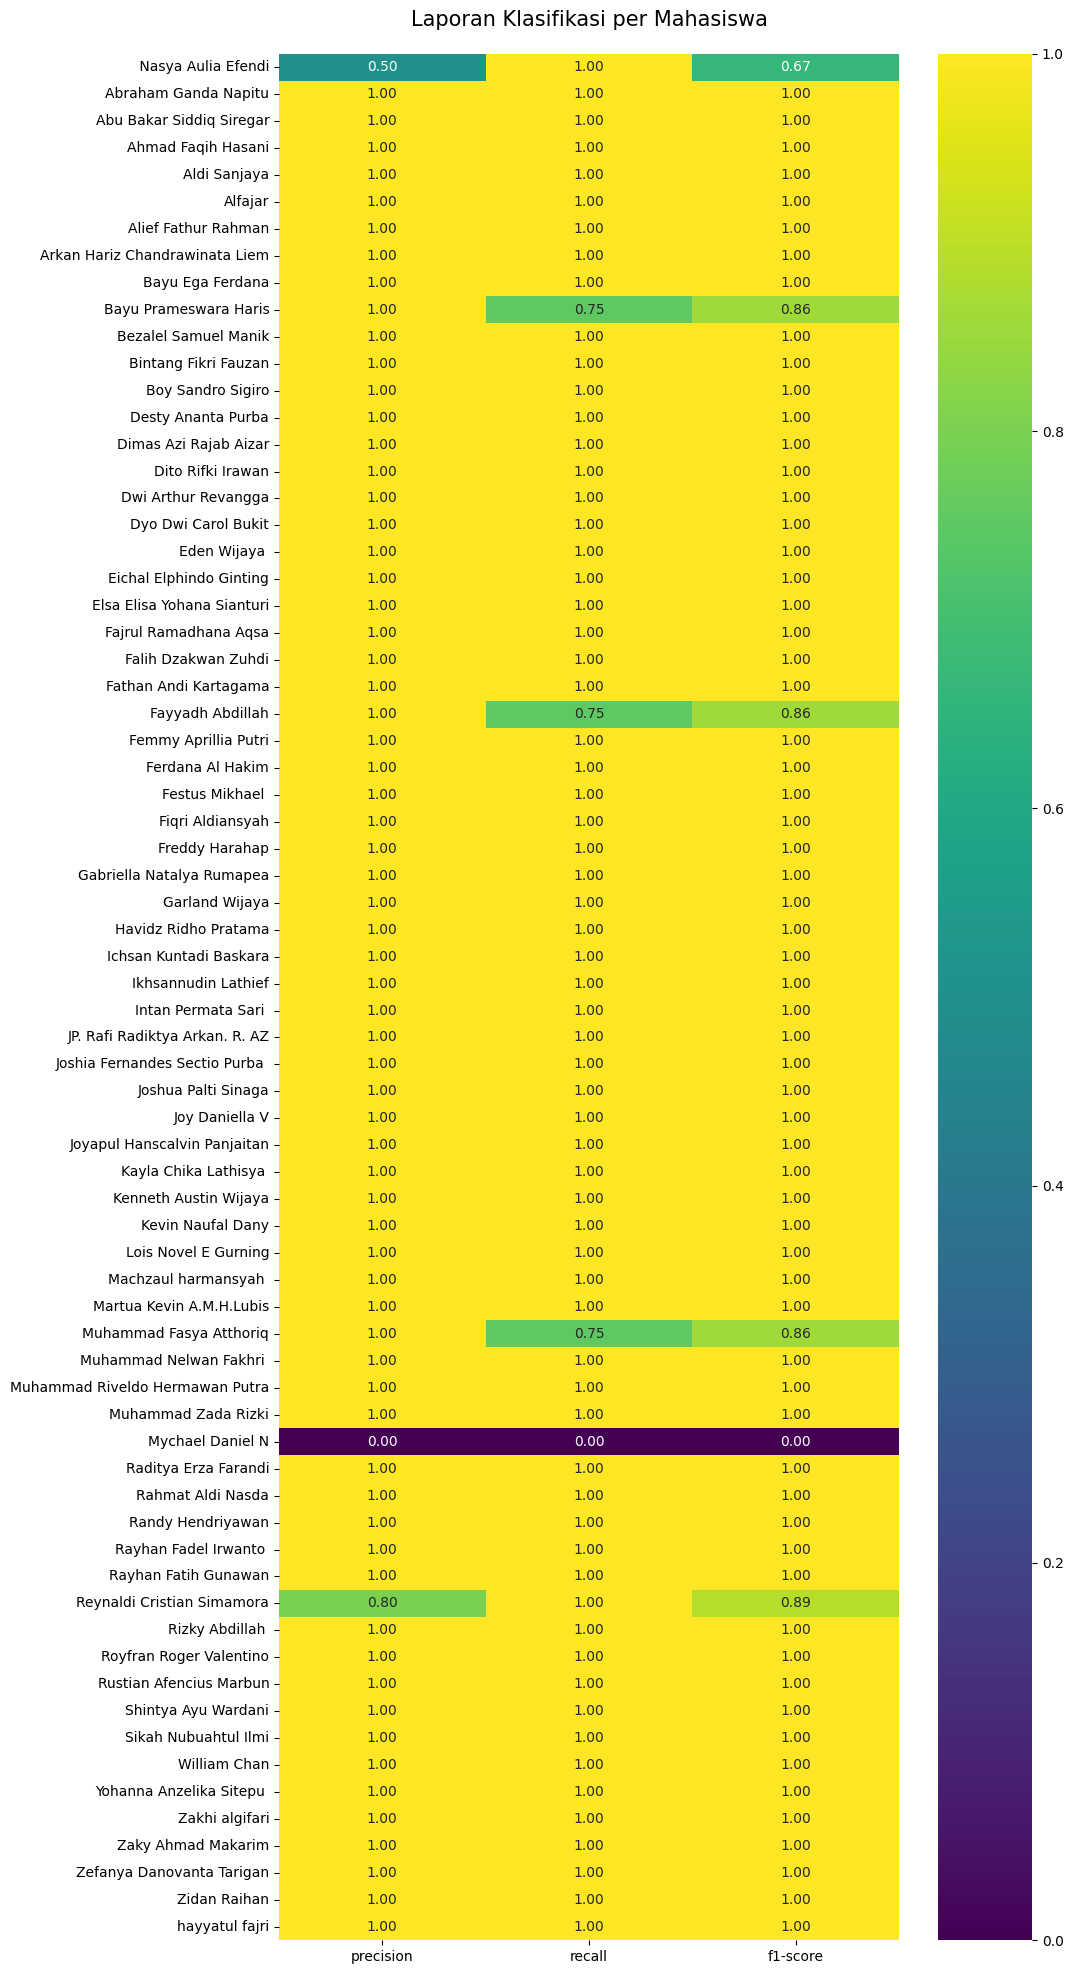

\ Visualisasi Confusion Matrix:


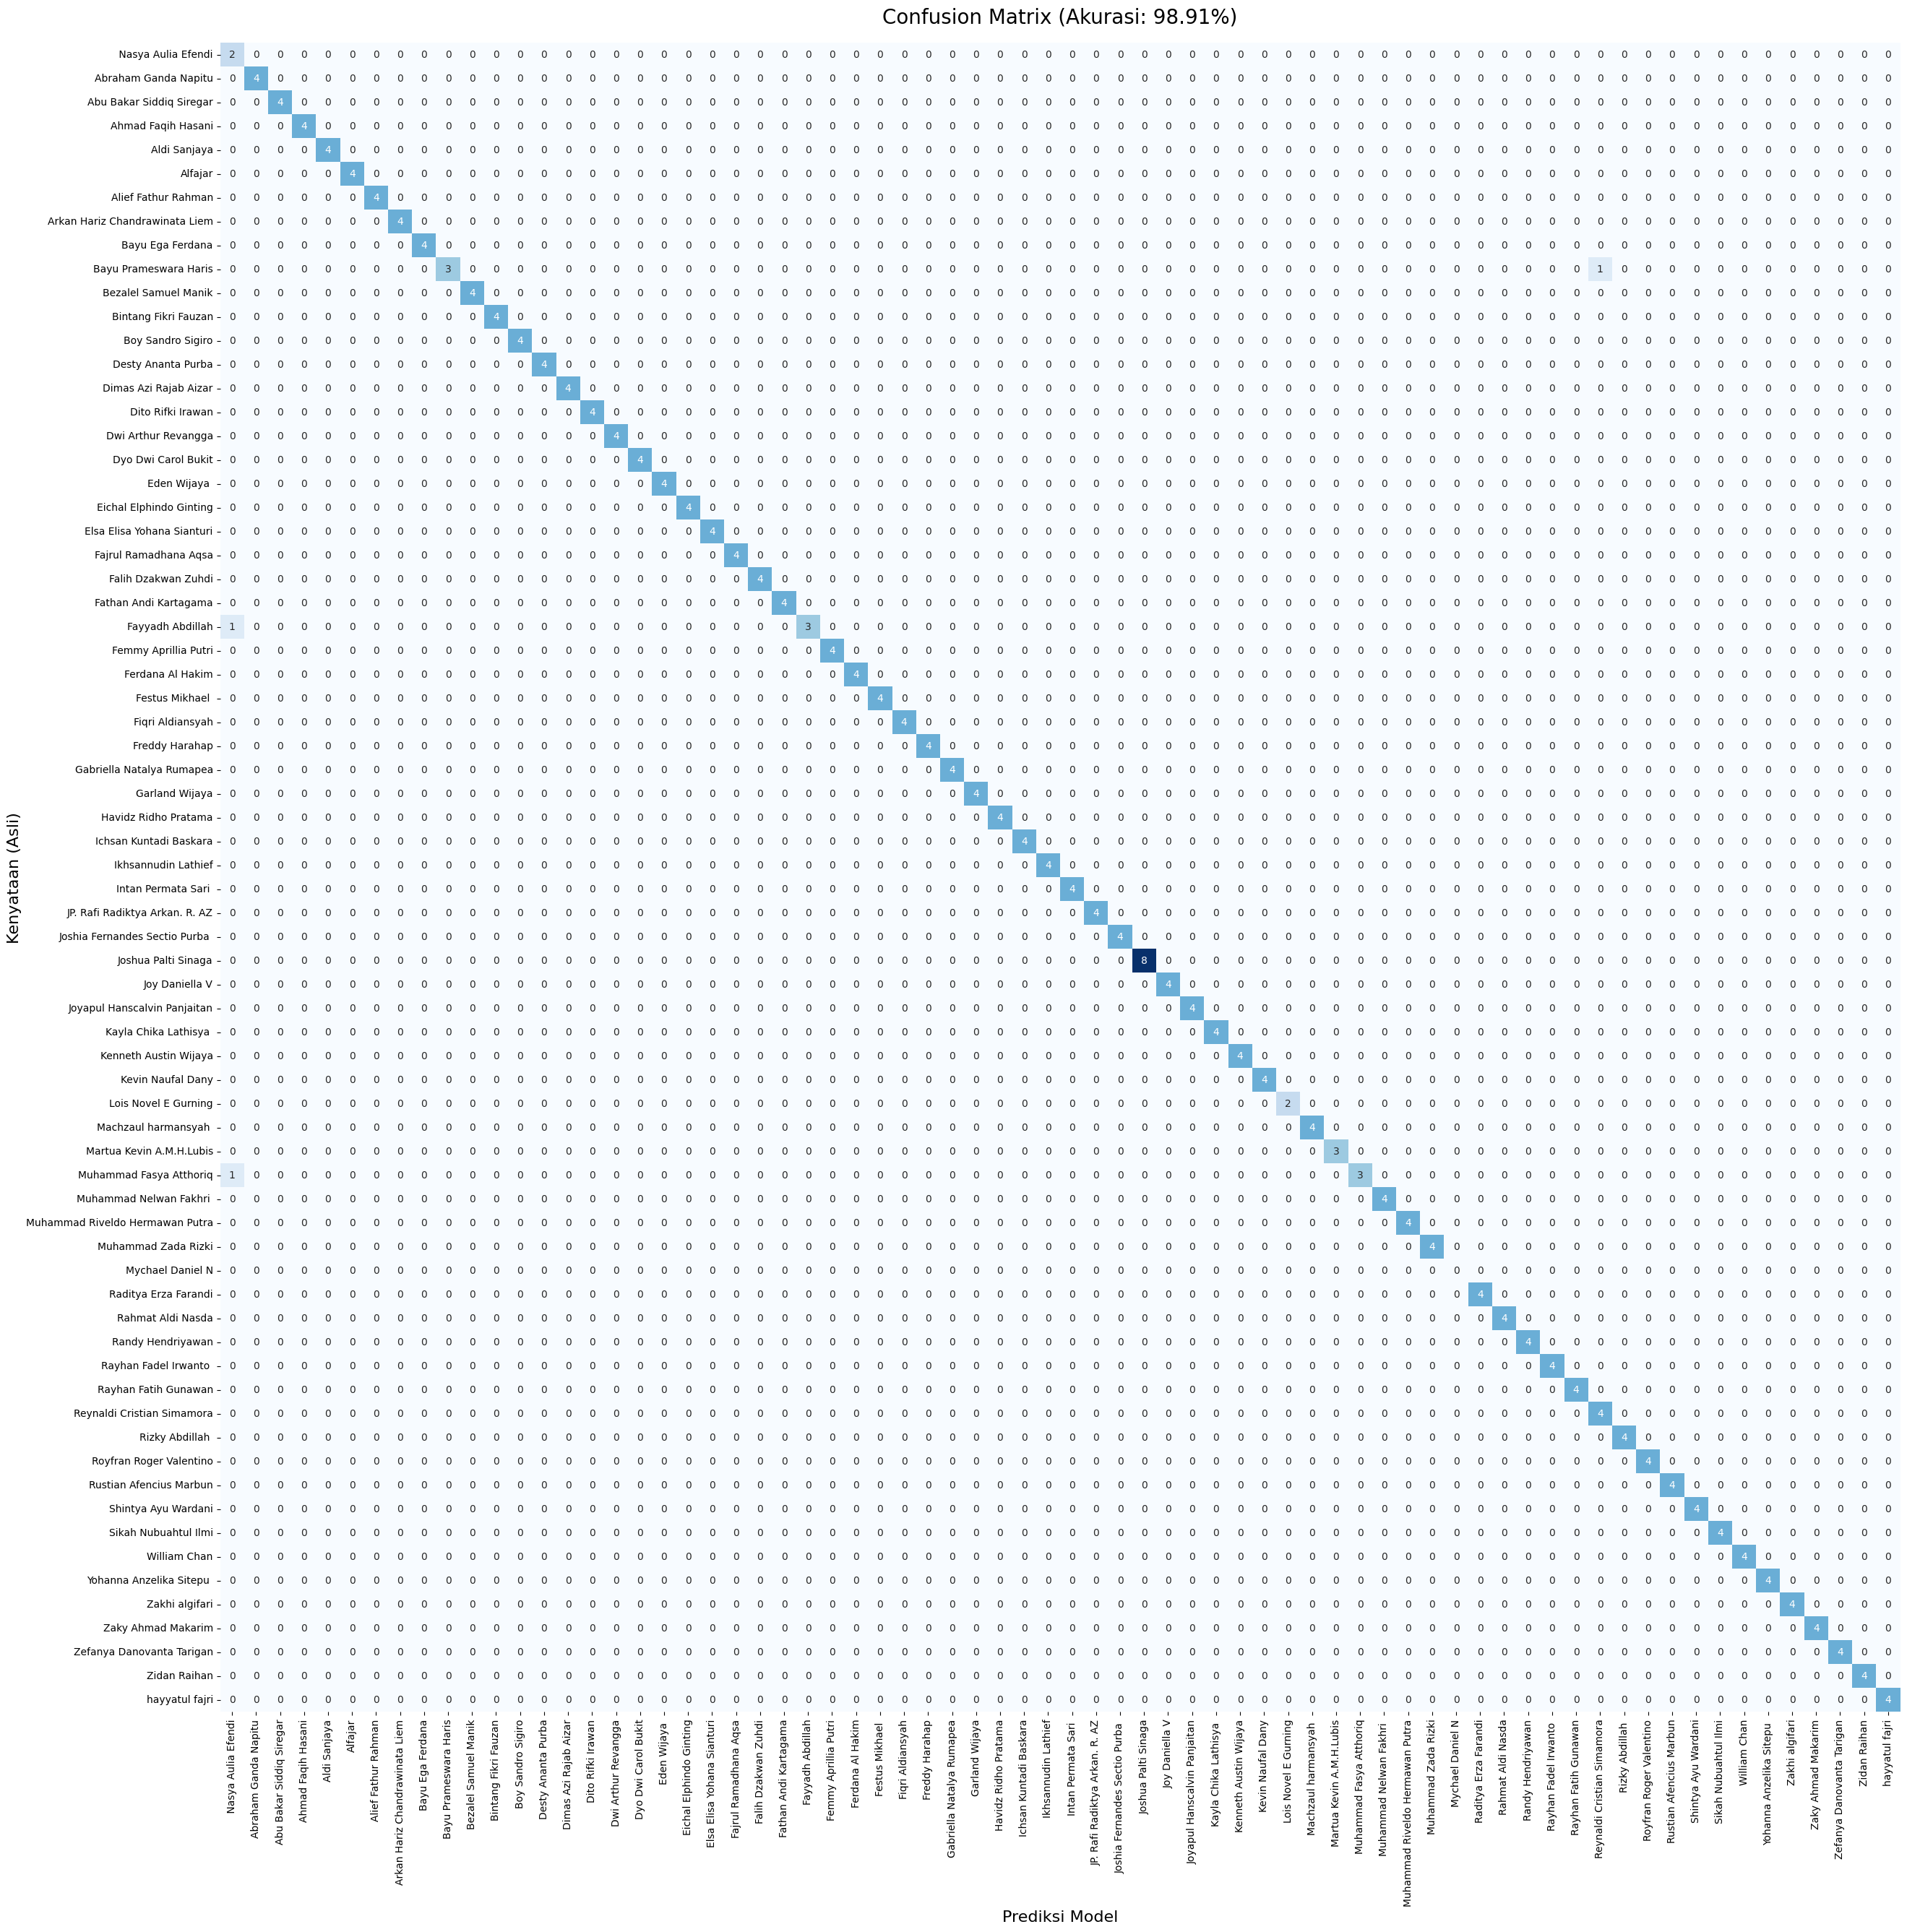

In [14]:
# CELL 8: Evaluasi Lengkap (Grafik Visualisasi)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("\nMenghitung Evaluasi Akhir...")

y_true = []
y_pred = []

# Pastikan list kelas ada
if 'classes' not in globals():
    classes = sorted(os.listdir(DB_DIR))

print(f"Total Kelas Terdeteksi: {len(classes)}")

# Loop testing
for cls in classes:
    cls_path = os.path.join(DB_DIR, cls)
    if not os.path.isdir(cls_path): continue

    # Cek apakah folder kosong
    if len(os.listdir(cls_path)) == 0:
        print(f"Peringatan: Folder '{cls}' kosong. Melewati...")
        continue

    for img_name in os.listdir(cls_path):
        try:
            img_path = os.path.join(cls_path, img_name)

            # Load & Preprocess
            img = image.load_img(img_path, target_size=IMG_SIZE)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            # Ekstrak Fitur
            feat = model_extractor.predict(x, verbose=0).flatten()
            feat = feat / np.linalg.norm(feat)

            # Bandingkan dengan Database
            best_score = -1
            best_name = "Unknown"

            for name, ref_feat in centroids.items():
                score = np.dot(feat, ref_feat)
                if score > best_score:
                    best_score = score
                    best_name = name

            y_true.append(cls)
            y_pred.append(best_name)
        except Exception as e:
            print(f"Error pada {img_name}: {e}")
            continue

# --- Visualisasi Hasil ---
acc = accuracy_score(y_true, y_pred)
print(f"\nAKURASI AKHIR: {acc*100:.2f}%")

# 1. Grafik Classification Report
print("\nVisualisasi Metrik (Precision, Recall, F1-Score):")

# PERBAIKAN: Menambahkan parameter 'labels=classes' agar tidak error jika ada kelas yg hilang
report_dict = classification_report(y_true, y_pred, target_names=classes, labels=classes, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()

# Hapus baris accuracy/macro avg/weighted avg agar grafik bersih
df_plot = df_report.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')[['precision', 'recall', 'f1-score']]

plt.figure(figsize=(10, len(classes) * 0.35))
sns.heatmap(df_plot, annot=True, cmap='viridis', fmt='.2f', cbar=True)
plt.title('Laporan Klasifikasi per Mahasiswa', fontsize=15, pad=20)
plt.yticks(rotation=0)
plt.show()

# 2. Grafik Confusion Matrix
print("\ Visualisasi Confusion Matrix:")
# PERBAIKAN: Menambahkan parameter 'labels=classes'
cm = confusion_matrix(y_true, y_pred, labels=classes)

plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes, cbar=False)
plt.xlabel('Prediksi Model', fontsize=16)
plt.ylabel('Kenyataan (Asli)', fontsize=16)
plt.title(f'Confusion Matrix (Akurasi: {acc*100:.2f}%)', fontsize=20, pad=20)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [18]:
from google.colab import files

print("Menyimpan model DenseNet terbaik (.h5) dan mengunduhnya...")

# Nama file untuk model yang akan disimpan
filename_model_densenet = 'densenet_best_model.h5'

# Pastikan model_extractor sudah ada dari sel sebelumnya
if 'model_extractor' in globals():
    try:
        model_extractor.save(filename_model_densenet)
        print(f"Model berhasil disimpan sebagai: {filename_model_densenet}")

        # Coba unduh file secara otomatis
        try:
            files.download(filename_model_densenet)
            print(f"File '{filename_model_densenet}' berhasil didownload.")
        except Exception as e:
            print(f"Gagal download otomatis: {e}. Silakan download manual dari panel kiri.")

    except Exception as e:
        print(f"Terjadi error saat menyimpan model: {e}")
else:
    print("Error: 'model_extractor' tidak ditemukan. Pastikan sel-sel sebelumnya sudah dijalankan.")
    print("Silakan jalankan sel 'Mengkonversi Model ke Feature Extractor...' terlebih dahulu.")


Menyimpan model DenseNet terbaik (.h5) dan mengunduhnya...
Model berhasil disimpan sebagai: densenet_best_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File 'densenet_best_model.h5' berhasil didownload.
